In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv(r"adult 3.csv")
print("Dataset loaded successfully.")
print(f"Initial shape: {data.shape}")
data.head()

Dataset loaded successfully.
Initial shape: (48842, 15)


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [3]:
data.info()
print("\nMissing values (represented by '?'):")
for col in data.columns:
    if (data[col] == '?').any():
        print(f"{col}: {(data[col] == '?').sum()} ({((data[col] == '?').sum() / len(data) * 100):.2f}%)")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB

Missing values (represented by '?'):
workclass: 2799 (5.73%)
occupation: 28

In [4]:
# Replace '?' with 'Others' for workclass and occupation
data.replace({'?': 'Others'}, inplace=True)

# Remove rows with 'Without-pay' and 'Never-worked' workclass
data = data[~data['workclass'].isin(['Without-pay', 'Never-worked'])]

# Remove lower education levels (as educational-num provides numerical representation)
data = data[~data['education'].isin(['5th-6th', '1st-4th', 'Preschool'])]

# Drop the 'education' column as 'educational-num' is kept
data.drop(columns=['education'], inplace=True)

# Filter 'age' column to remove potential outliers/unrealistic values
data = data[(data['age'] >= 17) & (data['age'] <= 75)]

print("\nData cleaning complete.")
print(f"New shape after cleaning: {data.shape}")
data.head()


Data cleaning complete.
New shape after cleaning: (47619, 14)


,age,workclass,fnlwgt,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,Others,103497,10,Never-married,Others,Own-child,White,Female,0,0,30,United-States,<=50K



--- Visualizing Distributions ---


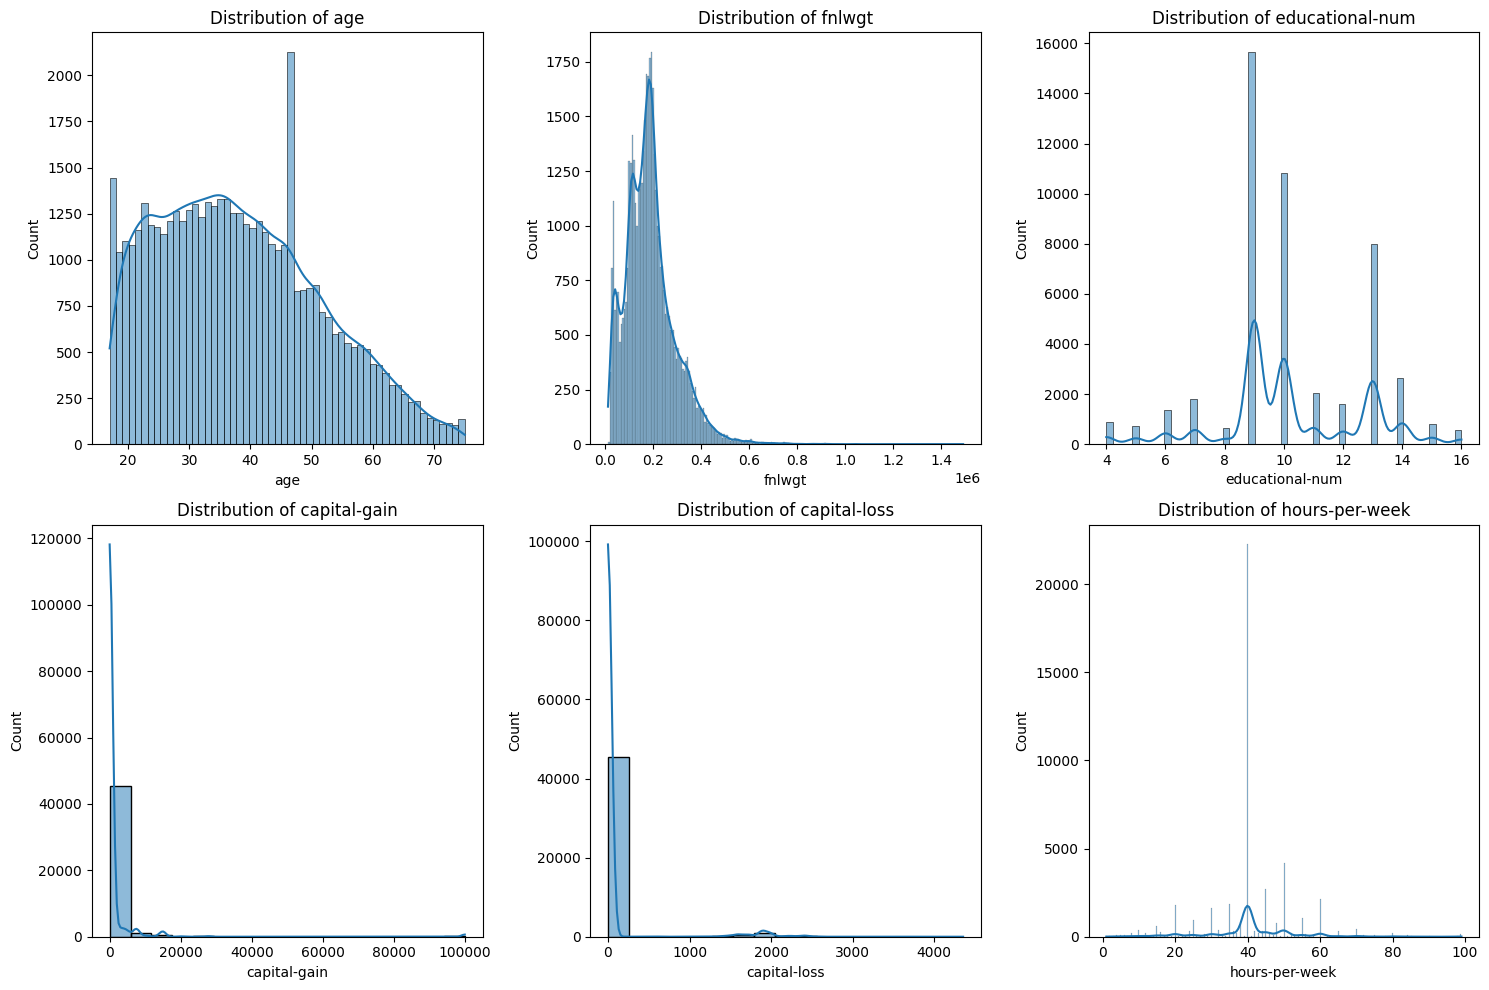

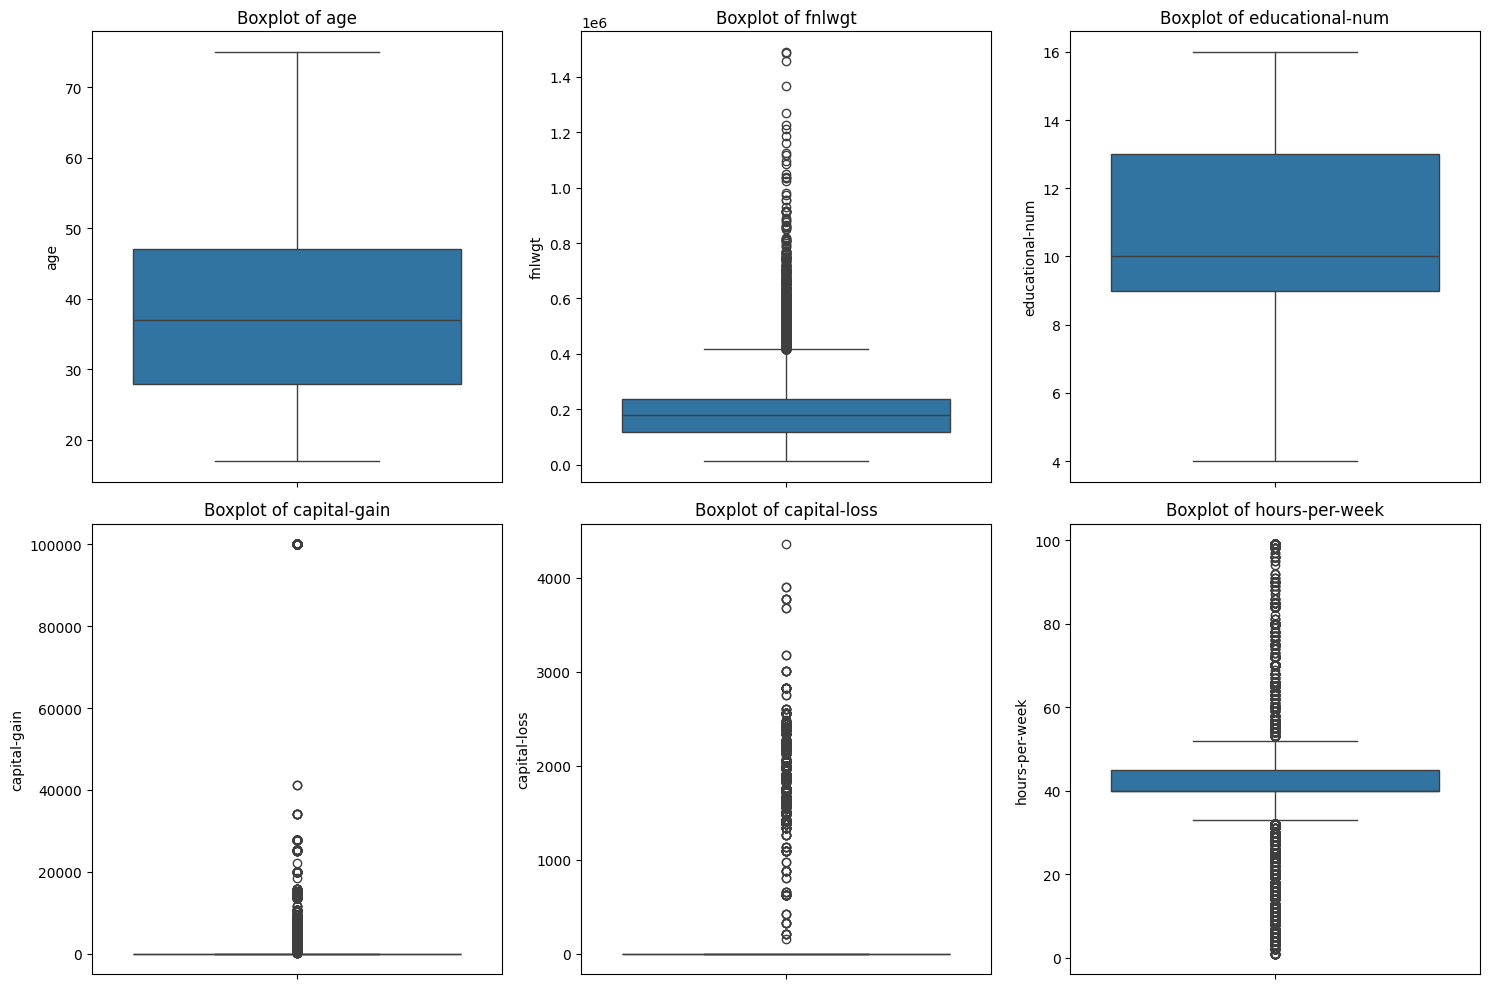

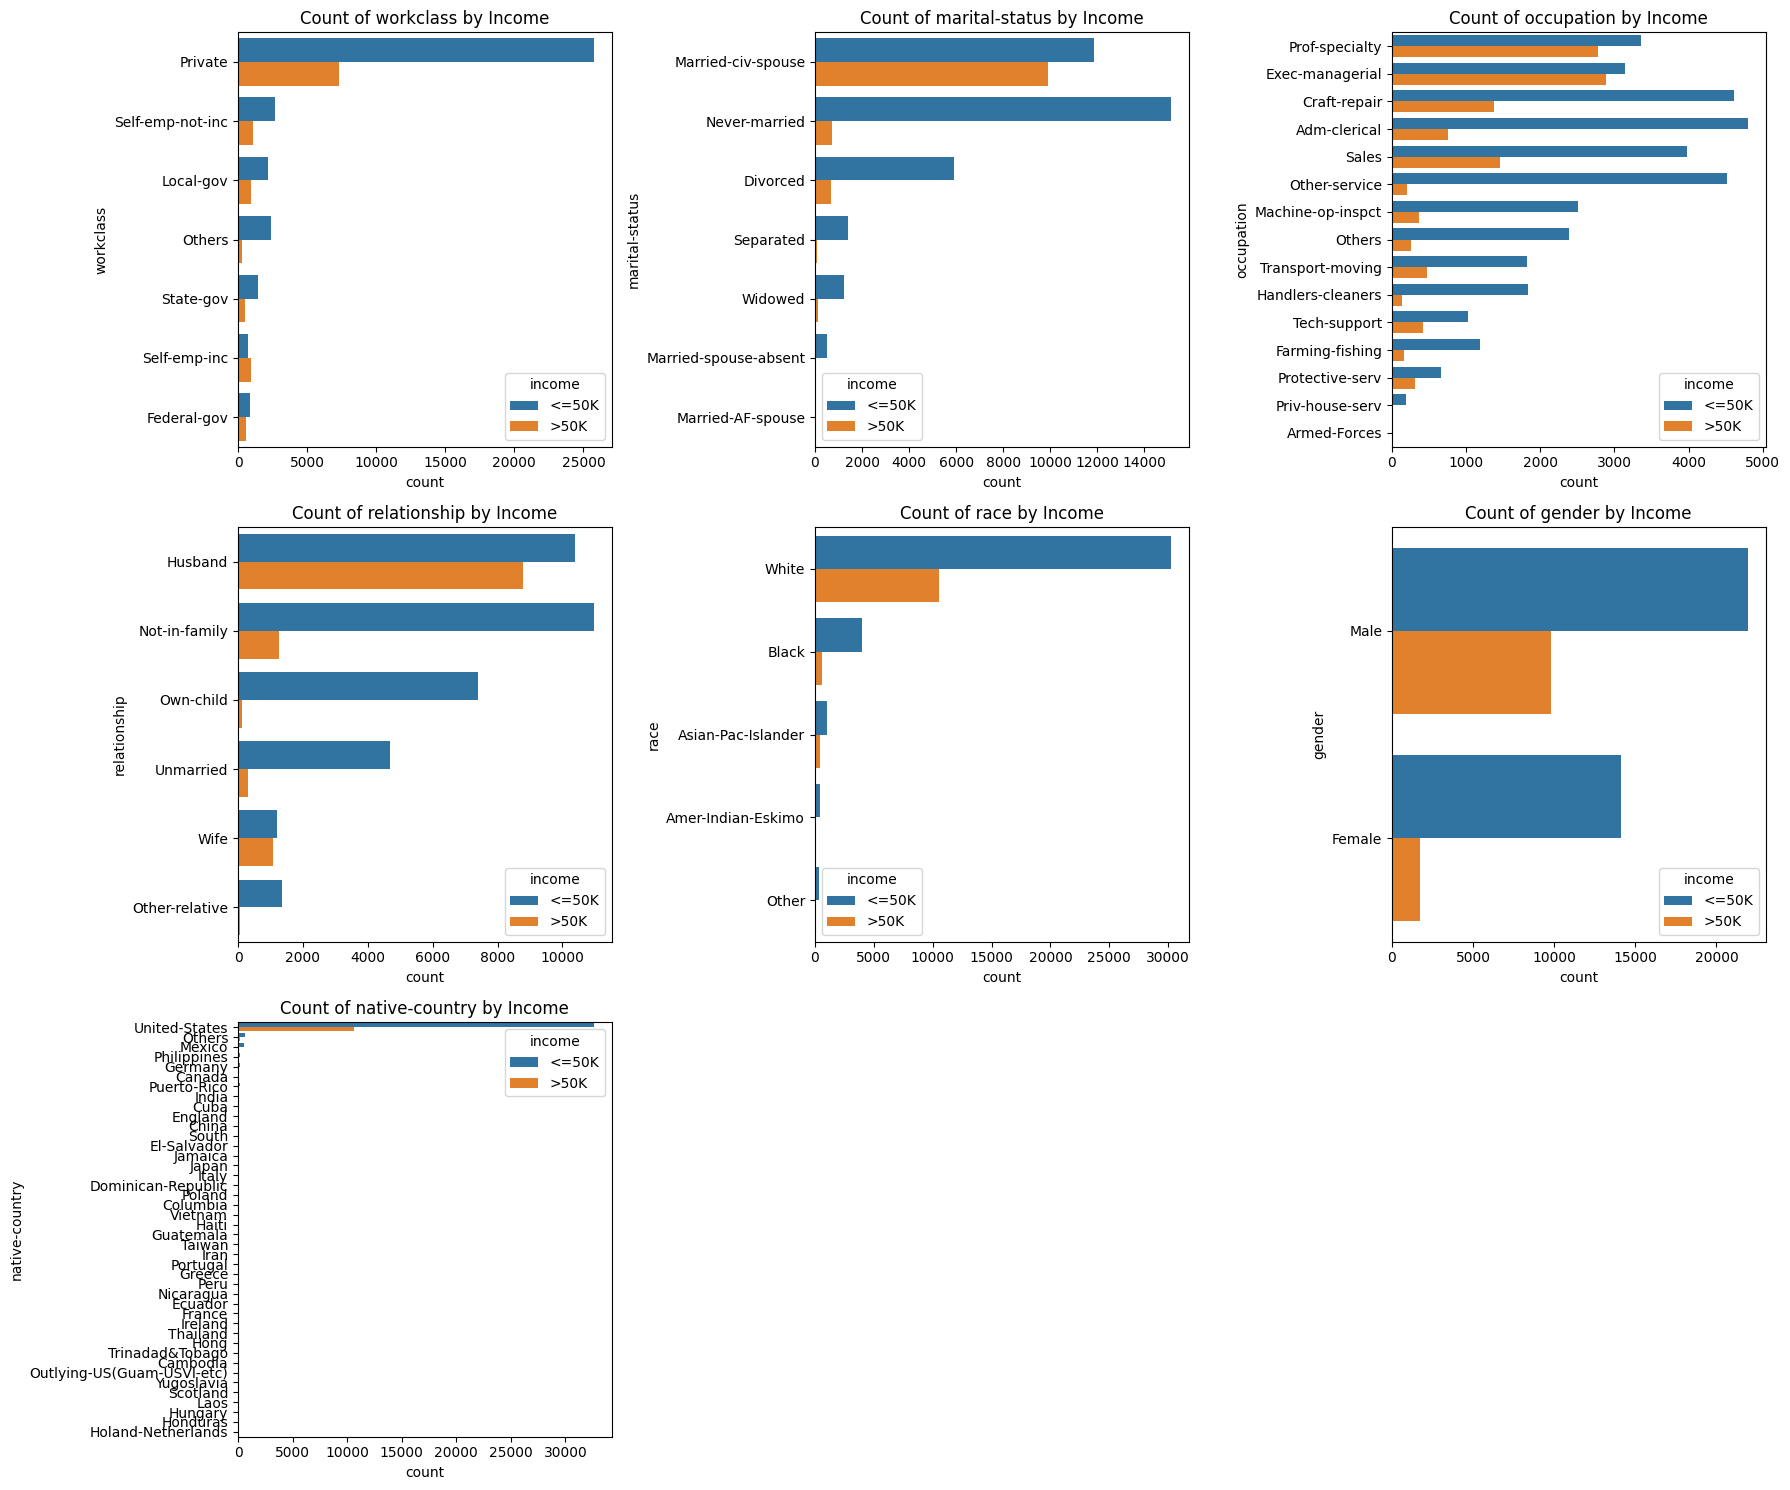

In [5]:
print("\n--- Visualizing Distributions ---")

# Numerical feature distributions
numerical_cols = ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Boxplots for numerical features to check for outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=data[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

# Categorical feature counts and income distribution
categorical_cols = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']
plt.figure(figsize=(18, 15))
for i, col in enumerate(categorical_cols):
    plt.subplot(3, 3, i + 1)
    sns.countplot(y=data[col], hue=data['income'], order=data[col].value_counts().index)
    plt.title(f'Count of {col} by Income')
plt.tight_layout()
plt.show()

In [6]:
X = data.drop(columns=['income'])
y = data['income']

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

# Encode the target variable (income) to numerical values
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("\nOriginal income categories:", le.classes_)
print("Encoded income categories (0 or 1):", np.unique(y_encoded))

# Split the data into training and testing sets
# Using stratify=y_encoded ensures that both train and test sets have similar proportions of income classes
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"\nTraining set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")

Features (X) shape: (47619, 13)
Target (y) shape: (47619,)

Original income categories: ['<=50K' '>50K']
Encoded income categories (0 or 1): [0 1]

Training set shape: (38095, 13), (38095,)
Testing set shape: (9524, 13), (9524,)


In [13]:
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

print(f"Numerical columns: {numerical_cols}")
print(f"Categorical columns: {categorical_cols}")

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()) # or StandardScaler() for mean=0, std=1
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # handle_unknown='ignore' for new categories in test/inference
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),\
        ('cat', categorical_transformer, categorical_cols)
    ])

print("Preprocessing pipeline created.\n")

Numerical columns: ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical columns: ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']
Preprocessing pipeline created.



In [14]:
models = {
    'KNeighborsClassifier': KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'), # Added class_weight
    'RandomForestClassifier': RandomForestClassifier(random_state=42, class_weight='balanced'), # Added class_weight
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42), # Does not directly support class_weight; can use sample_weight or different strategies
    'MLPClassifier': MLPClassifier(random_state=42, max_iter=1000) # Does not directly support class_weight; can use sample_weight or different strategies
}

results = {}
predictions = {}
probabilities = {}

print("--- Training and Evaluating Models ---")

for name, model in models.items():
    print(f"\nTraining {name}...\n")
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1] # Probability of the positive class (1)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    results[name] = {
        'accuracy': accuracy,\
        'report': report,
        'conf_matrix': conf_matrix,
        'roc_auc': roc_auc,
        'pipeline': pipeline # Store the trained pipeline
    }
    predictions[name] = y_pred
    probabilities[name] = y_proba
    
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(f"{name} ROC AUC: {roc_auc:.4f}")
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

--- Training and Evaluating Models ---

Training KNeighborsClassifier...

KNeighborsClassifier Accuracy: 0.8222
KNeighborsClassifier ROC AUC: 0.8465
Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

       <=50K       0.87      0.90      0.88      7206
        >50K       0.65      0.57      0.61      2318

    accuracy                           0.82      9524
   macro avg       0.76      0.74      0.75      9524
weighted avg       0.82      0.82      0.82      9524


Training LogisticRegression...

LogisticRegression Accuracy: 0.8118
LogisticRegression ROC AUC: 0.9071
Classification Report for LogisticRegression:
              precision    recall  f1-score   support

       <=50K       0.94      0.80      0.87      7206
        >50K       0.58      0.85      0.69      2318

    accuracy                           0.81      9524
   macro avg       0.76      0.83      0.78      9524
weighted avg       0.86      0.81      0.82      9524


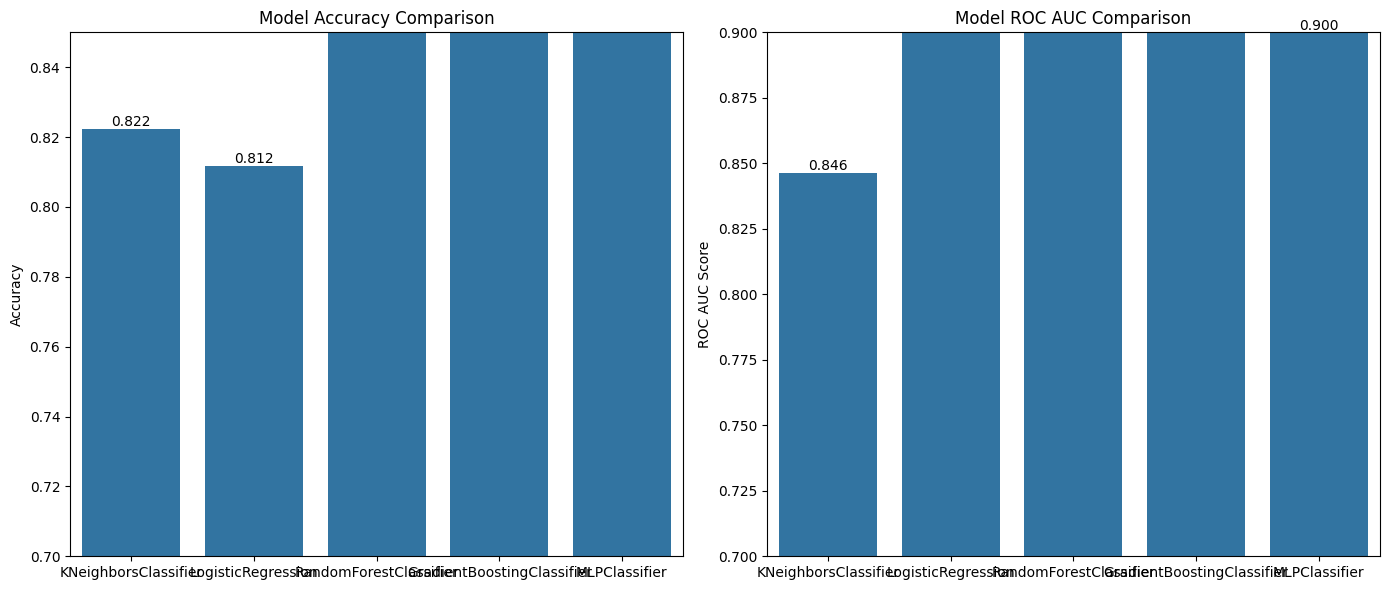

In [15]:
accuracy_scores = {name: res['accuracy'] for name, res in results.items()}
roc_auc_scores = {name: res['roc_auc'] for name, res in results.items()}

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy Plot
sns.barplot(x=list(accuracy_scores.keys()), y=list(accuracy_scores.values()), ax=ax[0])
ax[0].set_title('Model Accuracy Comparison')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0.7, 0.85) # Adjust limits for better visibility of differences
for p in ax[0].patches:
    ax[0].annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# ROC AUC Plot
sns.barplot(x=list(roc_auc_scores.keys()), y=list(roc_auc_scores.values()), ax=ax[1])
ax[1].set_title('Model ROC AUC Comparison')
ax[1].set_ylabel('ROC AUC Score')
ax[1].set_ylim(0.7, 0.9) # Adjust limits
for p in ax[1].patches:
    ax[1].annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

In [16]:
best_model_name = max(roc_auc_scores, key=roc_auc_scores.get)
best_pipeline = results[best_model_name]['pipeline']
print(f"Best performing model (based on ROC AUC): {best_model_name}")

# --- Hyperparameter Tuning for the Best Model (e.g., RandomForestClassifier) ---
if best_model_name == 'RandomForestClassifier':
    param_grid = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [10, 20, None],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 2]
    }
elif best_model_name == 'GradientBoostingClassifier':
    param_grid = {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.05, 0.1, 0.2],
        'classifier__max_depth': [3, 5]
    }
elif best_model_name == 'LogisticRegression':
    param_grid = {
        'classifier__C': [0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2']
    }
else:
    param_grid = {}
    print("No specific tuning grid defined for the best model type. Skipping tuning.")

if param_grid:
    print(f"\nPerforming GridSearchCV for {best_model_name}...")
    grid_search = GridSearchCV(best_pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    best_pipeline = grid_search.best_estimator_
    print(f"Best parameters found: {grid_search.best_params_}")
    print(f"Best cross-validation ROC AUC: {grid_search.best_score_:.4f}")

    # Evaluate the tuned model on the test set
    y_pred_tuned = best_pipeline.predict(X_test)
    y_proba_tuned = best_pipeline.predict_proba(X_test)[:, 1]

    tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
    tuned_roc_auc = roc_auc_score(y_test, y_proba_tuned)

    print(f"\n--- Tuned {best_model_name} Performance on Test Set ---")
    print(f"Accuracy: {tuned_accuracy:.4f}")
    print(f"ROC AUC: {tuned_roc_auc:.4f}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred_tuned, target_names=le.classes_)}")
else:
    print("Using the initially trained best model without further tuning.")

Best performing model (based on ROC AUC): GradientBoostingClassifier

Performing GridSearchCV for GradientBoostingClassifier...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200}
Best cross-validation ROC AUC: 0.9280

--- Tuned GradientBoostingClassifier Performance on Test Set ---
Accuracy: 0.8760
ROC AUC: 0.9309
Classification Report:
              precision    recall  f1-score   support

       <=50K       0.90      0.94      0.92      7206
        >50K       0.79      0.67      0.72      2318

    accuracy                           0.88      9524
   macro avg       0.84      0.81      0.82      9524
weighted avg       0.87      0.88      0.87      9524




--- Visualizing Final Model Performance ---


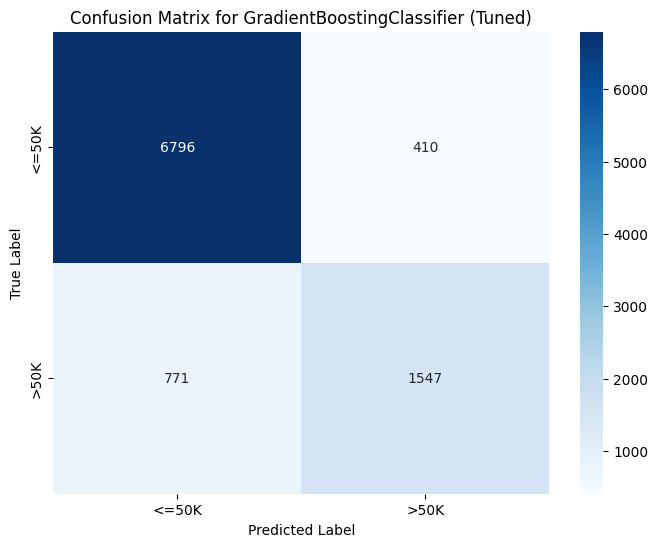

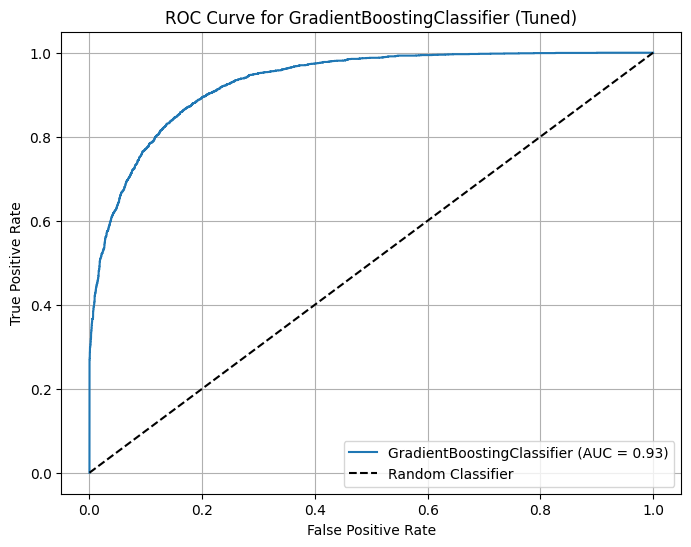

In [17]:
print("\n--- Visualizing Final Model Performance ---")

y_pred_final = best_pipeline.predict(X_test)
y_proba_final = best_pipeline.predict_proba(X_test)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix for {best_model_name} (Tuned)')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_final)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'{best_model_name} (AUC = {roc_auc_score(y_test, y_proba_final):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {best_model_name} (Tuned)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [18]:
model_filename = 'best_income_prediction_pipeline.joblib'
label_encoder_filename = 'income_label_encoder.joblib'

joblib.dump(best_pipeline, model_filename)
joblib.dump(le, label_encoder_filename)

print(f"\nBest model pipeline saved to '{model_filename}'")
print(f"LabelEncoder saved to '{label_encoder_filename}'")


Best model pipeline saved to 'best_income_prediction_pipeline.joblib'
LabelEncoder saved to 'income_label_encoder.joblib'
